使用裝置: cuda
✓ 中文字體設定成功
載入MNIST數據集...
訓練樣本數: 60000
測試樣本數: 10000

模型架構:
- 輸入維度: 784 (28x28)
- 隱藏層維度: 400
- 潛在空間維度: 20
- 總參數量: 652,824

開始訓練VAE模型...


Epoch 1: 100%|██████████| 469/469 [00:08<00:00, 53.80it/s, Loss=125.7662]


Epoch 1: 訓練損失=165.6713, 測試損失=120.2433


Epoch 2: 100%|██████████| 469/469 [00:08<00:00, 58.28it/s, Loss=115.3479]


Epoch 2: 訓練損失=122.0592, 測試損失=107.2157


Epoch 3: 100%|██████████| 469/469 [00:08<00:00, 56.35it/s, Loss=111.6983]


Epoch 3: 訓練損失=115.0548, 測試損失=102.9198


Epoch 4: 100%|██████████| 469/469 [00:08<00:00, 52.75it/s, Loss=111.6221]


Epoch 4: 訓練損失=112.0927, 測試損失=101.1729


Epoch 5: 100%|██████████| 469/469 [00:08<00:00, 52.99it/s, Loss=108.3338]


Epoch 5: 訓練損失=110.2488, 測試損失=99.9343

第5個epoch的重建結果:


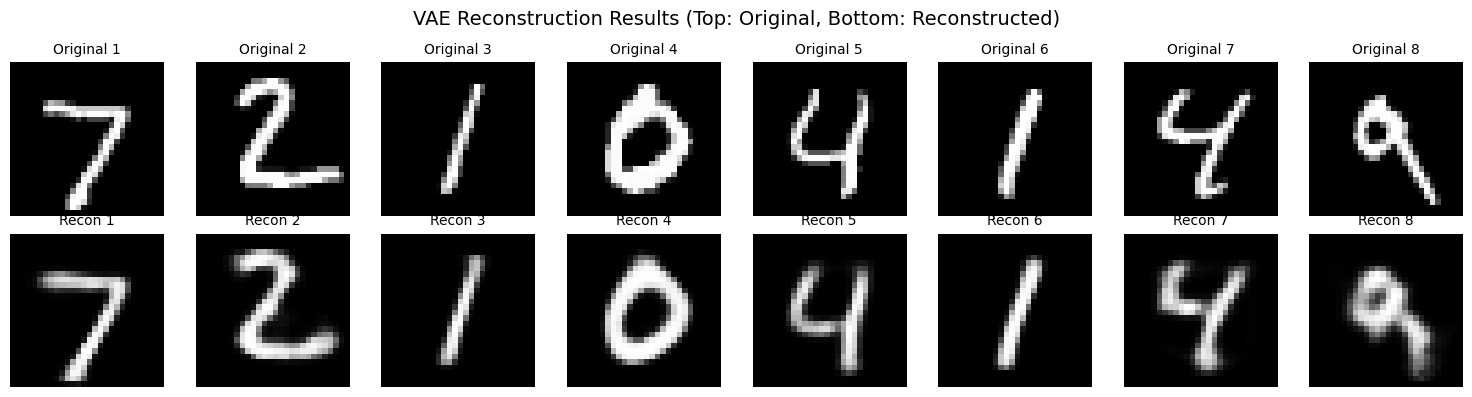

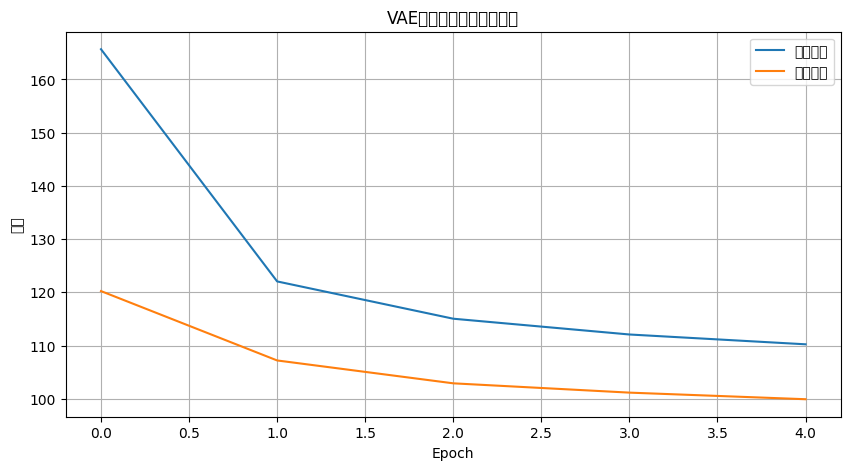


=== 最終結果展示 ===
1. 重建結果比較:


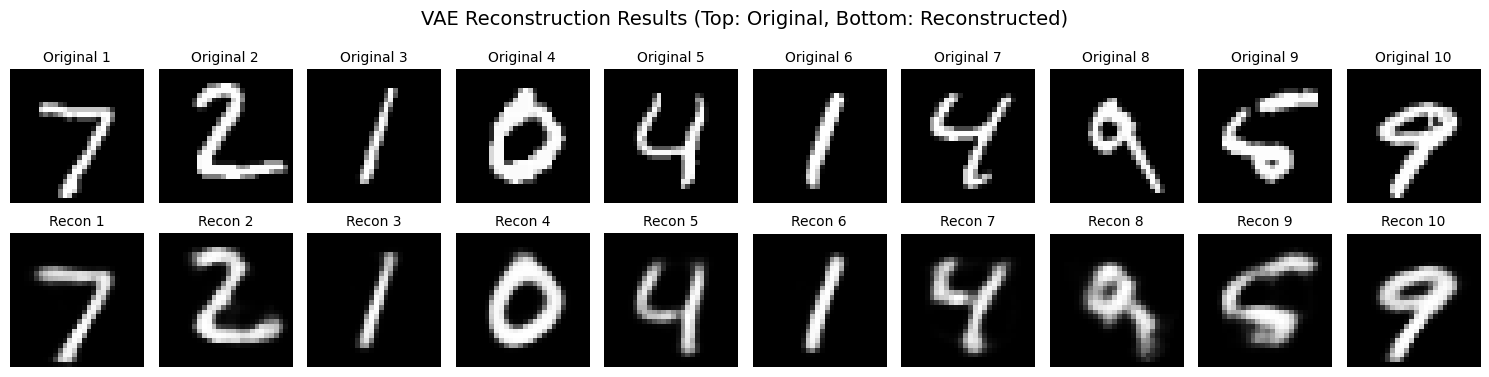


2. 生成新樣本:


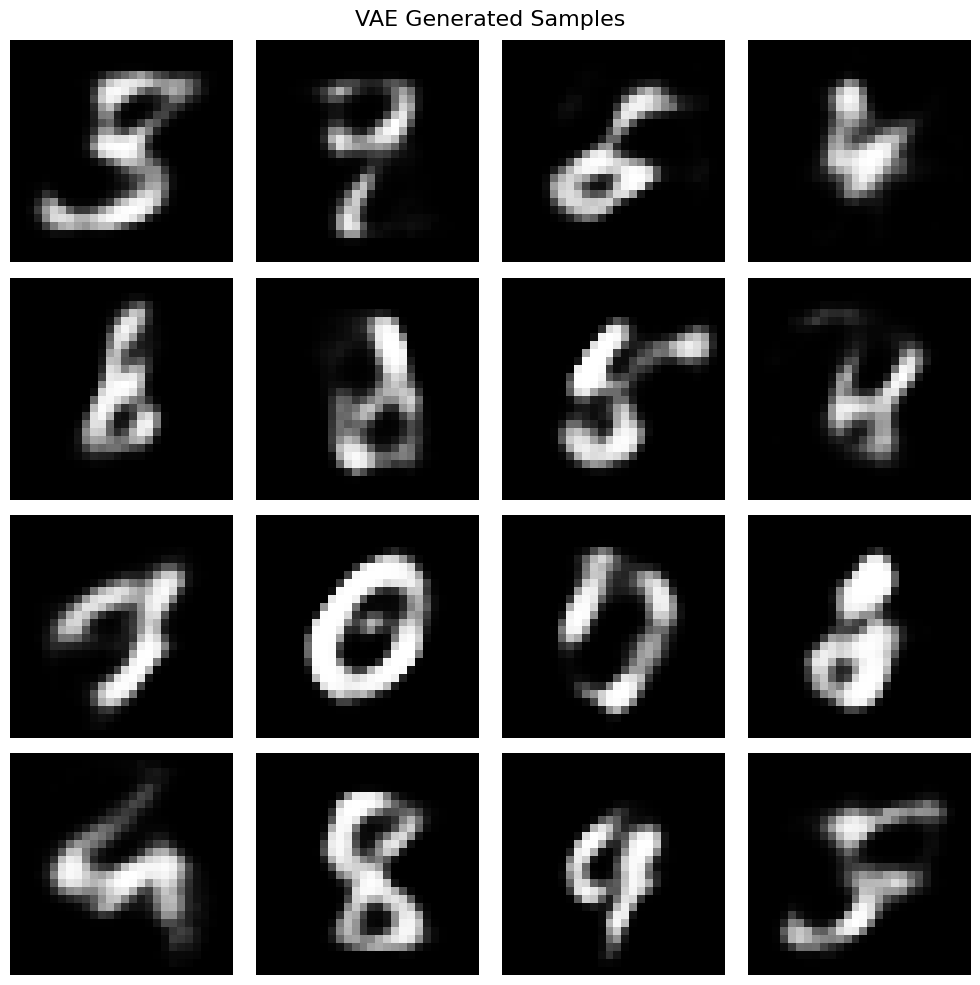


模型已保存至 'vae_mnist_model.pth'


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
import os
import platform

# 解決中文顯示問題
def setup_chinese_font():
    """簡化版中文字體設定 - 直接使用英文避免警告"""
    try:
        # 嘗試設定中文字體
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
        plt.rcParams['axes.unicode_minus'] = False

        # 測試中文顯示
        fig, ax = plt.subplots(figsize=(1, 1))
        ax.text(0.5, 0.5, '測試')
        plt.close(fig)
        print("✓ 中文字體設定成功")
        return True
    except:
        print("! 中文字體不可用，使用英文顯示避免警告")
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
        return False

# 設定裝置和中文字體
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')
chinese_support = setup_chinese_font()

class VAE(nn.Module):
    """變分自編碼器 (Variational Autoencoder)"""

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder部分
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # 均值 μ
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # 對數變異數 log(σ²)

        # Decoder部分
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """編碼器：將輸入編碼為潛在空間的均值和變異數"""
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """重參數化技巧：μ + σ * ε，其中 ε ~ N(0,1)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        """解碼器：從潛在變量重建輸入"""
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """前向傳播"""
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """VAE損失函數：重建損失 + KL散度"""
    # 重建損失（二元交叉熵）
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL散度：KL(q(z|x) || p(z))，其中 p(z) = N(0,I)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train_vae(model, train_loader, optimizer, epoch):
    """訓練VAE模型"""
    model.train()
    train_loss = 0

    with tqdm(train_loader, desc=f'Epoch {epoch}') as pbar:
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()

            # 前向傳播
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)

            # 反向傳播
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            # 更新進度條
            pbar.set_postfix({'Loss': f'{loss.item()/len(data):.4f}'})

    return train_loss / len(train_loader.dataset)

def test_vae(model, test_loader):
    """測試VAE模型"""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    return test_loss / len(test_loader.dataset)

def visualize_reconstruction(model, test_loader, num_images=8):
    """視覺化重建結果 - 統一使用英文避免字體問題"""
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

        # 統一使用英文標題避免字體警告
        fig.suptitle('VAE Reconstruction Results (Top: Original, Bottom: Reconstructed)',
                    fontsize=14)

        for i in range(num_images):
            # 原始圖像
            axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original {i+1}', fontsize=10)
            axes[0, i].axis('off')

            # 重建圖像
            axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].set_title(f'Recon {i+1}', fontsize=10)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

def generate_samples(model, num_samples=16, latent_dim=20):
    """從潛在空間生成新樣本 - 統一使用英文"""
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)

        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        fig.suptitle('VAE Generated Samples', fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(samples[i].cpu().view(28, 28), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

def main():
    # 超參數設定
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 5
    latent_dim = 20

    # 數據預處理
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # 載入MNIST數據集
    print("載入MNIST數據集...")
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"訓練樣本數: {len(train_dataset)}")
    print(f"測試樣本數: {len(test_dataset)}")

    # 初始化模型
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"\n模型架構:")
    print(f"- 輸入維度: 784 (28x28)")
    print(f"- 隱藏層維度: 400")
    print(f"- 潛在空間維度: {latent_dim}")
    print(f"- 總參數量: {sum(p.numel() for p in model.parameters()):,}")

    # 訓練循環
    print(f"\n開始訓練VAE模型...")
    train_losses = []
    test_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_vae(model, train_loader, optimizer, epoch)
        test_loss = test_vae(model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch {epoch}: 訓練損失={train_loss:.4f}, 測試損失={test_loss:.4f}')

        # 每5個epoch視覺化一次結果
        if epoch % 5 == 0:
            print(f"\n第{epoch}個epoch的重建結果:")
            visualize_reconstruction(model, test_loader)

    # 繪製訓練曲線
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='訓練損失')
    plt.plot(test_losses, label='測試損失')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.title('VAE訓練過程中的損失變化')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 最終結果展示
    print("\n=== 最終結果展示 ===")
    print("1. 重建結果比較:")
    visualize_reconstruction(model, test_loader, num_images=10)

    print("\n2. 生成新樣本:")
    generate_samples(model, num_samples=16, latent_dim=latent_dim)

    # 保存模型
    torch.save(model.state_dict(), 'vae_mnist_model.pth')
    print("\n模型已保存至 'vae_mnist_model.pth'")

    return model

if __name__ == "__main__":
    model = main()